# **Background**
___________________________________
In this kernel I will perform some exploratory data analysis on the Google Merchandise store. I will take a sample of this data from 2016Q4 (October 2016 to December 2016), and provide some descriptive analysis on the site's performance. I will explore: 

1. **High-level Website Performance Overview:** What was the aggregate traffic and trends seen during this quarter?
2. **Website Acquisition:** Where are users originating from and their conversions?
3. **User Behavior:** How are users navigating to the Google Merchandise store and what are they purchasing?

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# import libraries
import bq_helper
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

set_matplotlib_formats('retina')
%matplotlib inline

from google.cloud import bigquery
client = bigquery.Client()

Using Kaggle's public dataset BigQuery integration.


# 1. High Level Stats
__________________________
I will summarize the quarterly stats for 2016Q4 similar to a Google Analytics canned report. 

In [3]:
# high level stats 

query = """
    SELECT 
        FORMAT("%'d",COUNT(DISTINCT fullVisitorId)) AS users,
        FORMAT("%'d",SUM(totals.visits)) AS visits,
        FORMAT("%'d",SUM(totals.pageviews)) AS pageviews,
        FORMAT("%'d", SUM(totals.transactions)) AS transactions,
        SUM(totals.transactionRevenue)/1000000 AS revenue

    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
        AND totals.totalTransactionRevenue IS NOT NULL
        
"""
safe_query_job = client.query(query)
high_level_aug = safe_query_job.to_dataframe()
high_level_aug

,users,visits,pageviews,transactions,revenue
0,"2,868","3,176","92,822","3,314",386199.7


During 2016Q4, the Google Merchandise Store had over 3,000 visits, almost 93,000 pageviews and earned $386,200 in revenue.

In [4]:
# traffic by month
query = """
    SELECT 
        DATE_TRUNC(PARSE_DATE('%Y%m%d',date), MONTH) AS month,
        SUM(totals.visits) AS visits,        
        SUM(totals.transactionRevenue)/1000000 AS revenue

    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
        AND totals.totalTransactionRevenue IS NOT NULL
    GROUP BY 1
    ORDER BY 1
        
"""
safe_query_job = client.query(query)
df_1 = safe_query_job.to_dataframe()
df_1.head(3)

,month,visits,revenue
0,2016-10-01,872,113329.07
1,2016-11-01,919,119013.87
2,2016-12-01,1385,153856.76


December generated over $153,000 in revenue and garnered almost 1,400 visits to the Google Merchandise store. The revenue generated in December accounted for 40% of Q4 sales, indicating a holiday surge that is typically seen in retail.

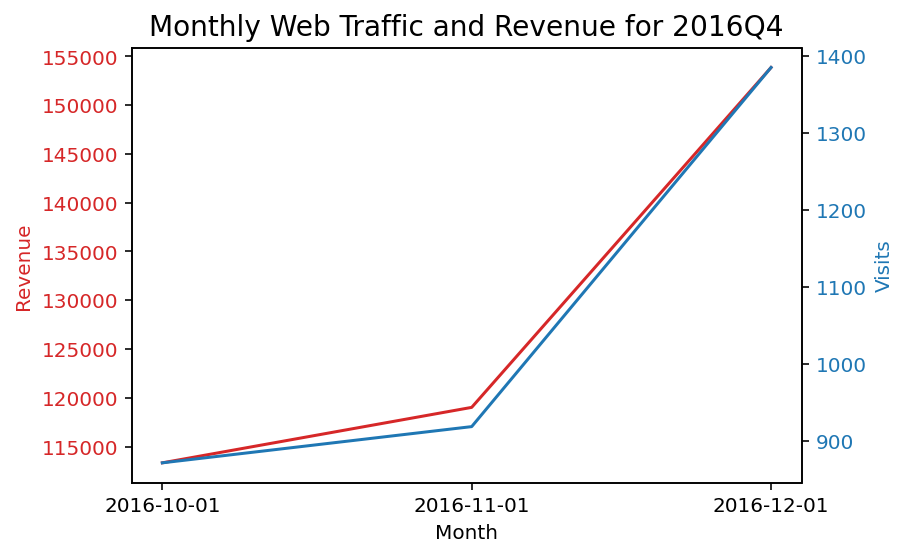

In [5]:
# plot web traffic and revenue by month for Q4

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Revenue', color=color)
ax1.plot(df_1['month'], df_1['revenue'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Visits', color=color)  # we already handled the x-label with ax1
ax2.plot(df_1['month'], df_1['visits'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Monthly Web Traffic and Revenue for 2016Q4', fontsize=14)
plt.xticks(df_1['month'],rotation=45)
plt.show()

In [6]:
# create a table with revenue by country

# traffic by month
query = """
    SELECT 
        geoNetwork.country AS country,   
        SUM(totals.transactionRevenue)/1000000 AS revenue

    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
        AND totals.totalTransactionRevenue IS NOT NULL
    GROUP BY 1
    ORDER BY 2 desc
    
"""
safe_query_job = client.query(query)
df_2 = safe_query_job.to_dataframe()
df_2.head(5)

,country,revenue
0,United States,365518.96
1,Canada,9975.27
2,Kenya,3679.30
3,Puerto Rico,656.16
4,United Kingdom,527.10


The majority of revenue is generated from US-based transactions.

In [7]:
# create a heatmap of revenue by geo location

fig = go.Figure(data=go.Choropleth(
    locations=df_2['country'], # Spatial coordinates
    z = df_2['revenue'].astype(float), # Data to be color-coded
    locationmode = 'country names', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "revenue USD",
))

fig.update_layout(
    title_text = '2016Q4 Google Merchandise Store by Geo Location',
)

fig.show()

# 2. Website Acquisition
________________________
This section will provide an overview of the top channels sending visitors to the Google Merchandise store. 

In [8]:
# create a table of metrics by channel

query = """
    SELECT
        channelGrouping as channel,
        SUM(totals.totalTransactionRevenue)/1000000 AS revenue,
        SUM(totals.transactions) AS transactions,
        COUNT(DISTINCT fullVisitorId) AS users,
        SUM(totals.visits) AS sessions,
        SUM(totals.pageviews) AS pageviews
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
        AND totals.totalTransactionRevenue IS NOT NULL
    GROUP BY
        1
    ORDER BY
        2 DESC
"""
safe_query_job = client.query(query)
df_3 = safe_query_job.to_dataframe()
df_3.head(3)

,channel,revenue,transactions,users,sessions,pageviews
0,Referral,182578.60,1540,1331,1470,42829
1,Direct,128141.06,568,456,539,16132
2,Organic Search,93376.88,991,905,956,28247


As we can see from the visualization below, Referral traffic has generated the most revenue as well as garnered the most users to the Google Merchandise store. Interestingly, while Direct traffic has generated more revenue than Organic Search, Organic Search has led to more transactions and users during this fiscal quarter.     

Text(0.5, 1.0, 'Total Pageviews by Channel')

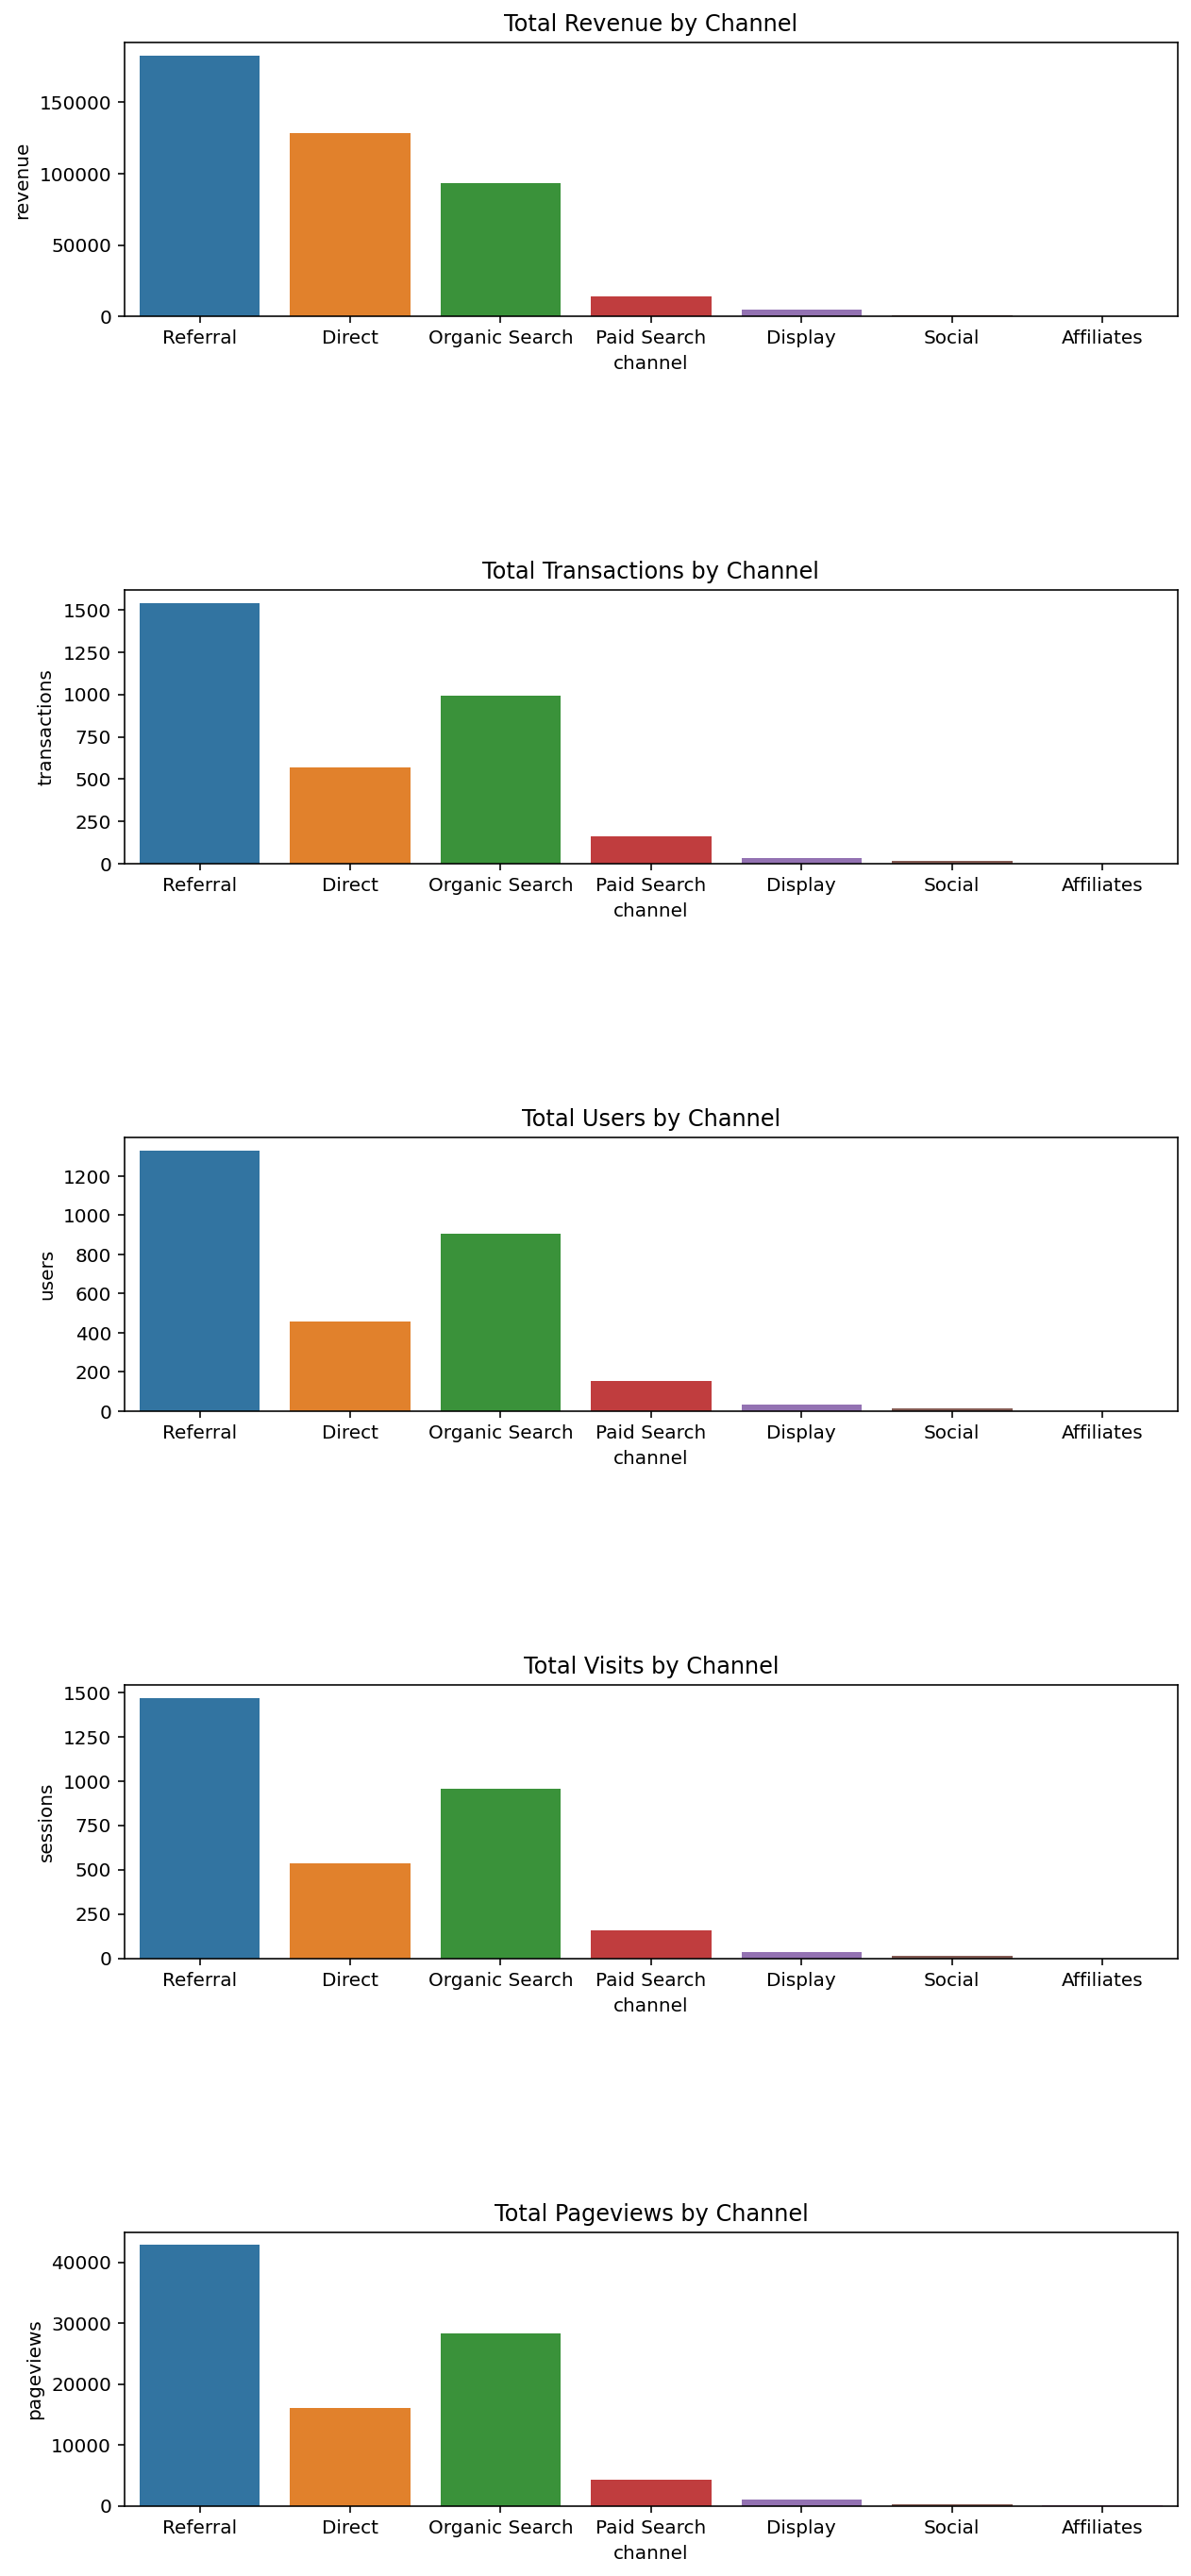

In [9]:
# set up the matplotlib figure
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(10,24))
fig.subplots_adjust(hspace=1)

sns.barplot(x='channel',
            y='revenue',
            data=df_3,
            estimator=sum,
            ax=ax1)

sns.barplot(x='channel',
            y='transactions',
            data=df_3,
            estimator=sum,
            ax=ax2)

sns.barplot(x='channel',
            y='users',
            data=df_3,
            estimator=sum,
            ax=ax3)

sns.barplot(x='channel',
            y='sessions',
            data=df_3,
            estimator=sum,
            ax=ax4)

sns.barplot(x='channel',
            y='pageviews',
            data=df_3,
            estimator=sum,
            ax=ax5)

ax1.set_title('Total Revenue by Channel')
ax2.set_title('Total Transactions by Channel')
ax3.set_title('Total Users by Channel')
ax4.set_title('Total Visits by Channel')
ax5.set_title('Total Pageviews by Channel')

# 3. User Behavior


This section will begin to study users behavior on the Google Merchandise store. 

### Are users more likely to transact the longer they visit the site? Or are they more likely to transact with the more browsing on site (# of pageviews)? 

We calculated the Pearson coefficient of correlation for these two features (pageviews and average time on site) and transactions. A coefficient close to 1 means that there's a strong correlation between the two variables. As we can see on the heat map, pageviews are more positively correlated with transactions than average time on site with transactions. This could indicate site browsing as a key indicator that may lead to transactions.

In [10]:
# create a data frame with features
query = """
    SELECT 
        fullVisitorId AS userID,
        AVG(totals.timeOnSite) As avgTimeOnSite,
        SUM(totals.pageviews) AS pageviews,
        SUM(totals.transactions) AS transactions
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
    GROUP BY
        1
    ORDER BY 1
        
"""
safe_query_job = client.query(query)
df_4 = safe_query_job.to_dataframe()
df_4.head(4)

,userID,avgTimeOnSite,pageviews,transactions
0,0000010278554503158,194.0,8.0,NaN
1,0000020424342248747,297.0,13.0,NaN
2,0000152474579038632,162.0,2.0,NaN
3,0000174067426171406,559.5,30.0,NaN


In [11]:
# replace na values with 0
df_4['transactions'].fillna(0, inplace=True)
df_4.head(4)

,userID,avgTimeOnSite,pageviews,transactions
0,0000010278554503158,194.0,8.0,0.0
1,0000020424342248747,297.0,13.0,0.0
2,0000152474579038632,162.0,2.0,0.0
3,0000174067426171406,559.5,30.0,0.0


In [12]:
pearsoncorr = df_4.corr(method='pearson')
pearsoncorr

,avgTimeOnSite,pageviews,transactions
avgTimeOnSite,1.000000,0.454428,0.242365
pageviews,0.454428,1.000000,0.525083
transactions,0.242365,0.525083,1.000000


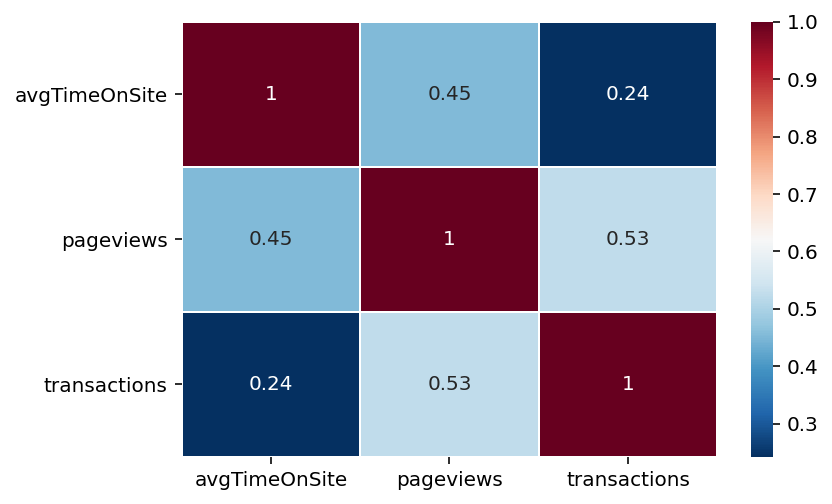

In [13]:
# create a heat map of features
sns.heatmap(pearsoncorr,
              xticklabels=pearsoncorr.columns,
              yticklabels=pearsoncorr.columns,
              cmap='RdBu_r',
              annot=True,
              linewidth=0.5)

### What are the most visited pages on the site? 
/google+redesign/ has garnered the most pageviews followed by /home. 

In [14]:
# create a data frame with features
query = """
    SELECT
        hits.page.pagePathLevel1 AS pagePath,
        SUM(totals.pageviews) AS pageviews
    FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
      UNNEST(hits) AS hits
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 10
"""
safe_query_job = client.query(query)
df_5 = safe_query_job.to_dataframe()
df_5

,pagePath,pageviews
0,/google+redesign/,13059899
1,/home,2320076
2,/basket.html,2251571
3,/store.html,693064
4,/signin.html,373752
5,/asearch.html,342792
6,/yourinfo.html,309919
7,/payment.html,305266
8,/ordercompleted.html,214672
9,/revieworder.html,144310


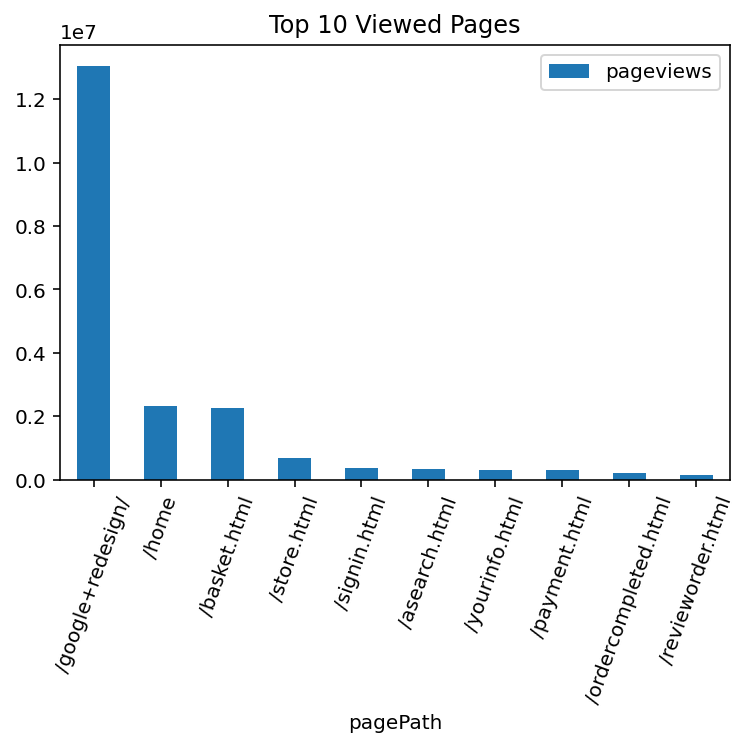

In [15]:
# create a bar chart of top 10 pages with most pageviews
df_5.plot.bar(x='pagePath', y='pageviews', rot=70, title='Top 10 Viewed Pages');
plt.show();

### What was the most popular purchase during Q4?

While Apparel generated the most revenue during Q4, Office Supplies were sold the most. 

In [16]:
# create a data frame calling product features
query = """
    SELECT
        product.v2ProductCategory AS product_category,
        product.v2ProductName AS product_name,
        product.productSKU AS product_sku,
        product.productPrice/1e6 AS product_price,
        product.productQuantity AS product_quantity,
        product.productRevenue/1e6 AS product_revenue,
        totals.totalTransactionRevenue/1e6 AS total_revenue
    FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
      UNNEST(hits) AS hits,
      UNNEST(hits.product) AS product
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
        AND productRevenue IS NOT NULL
"""
safe_query_job = client.query(query)
df_6 = safe_query_job.to_dataframe()
df_6.head(3)

,product_category,product_name,product_sku,product_price,product_quantity,product_revenue,total_revenue
0,Drinkware,Engraved Ceramic Google Mug,GGOEGDWC020199,7.19,1,11.19,11.19
1,Apparel,Google Men's 100% Cotton Short Sleeve Hero Tee...,GGOEGAAB010516,16.99,1,18.39,1015.48
2,Apparel,Google Men's 100% Cotton Short Sleeve Hero Tee...,GGOEGAAR010716,16.99,1,18.39,1015.48


In [17]:
# clean values under product_category
df_6['product_category'].unique()
df_6 = df_6.replace(['${productitem.product.origCatName}'], 'Miscellaneous')

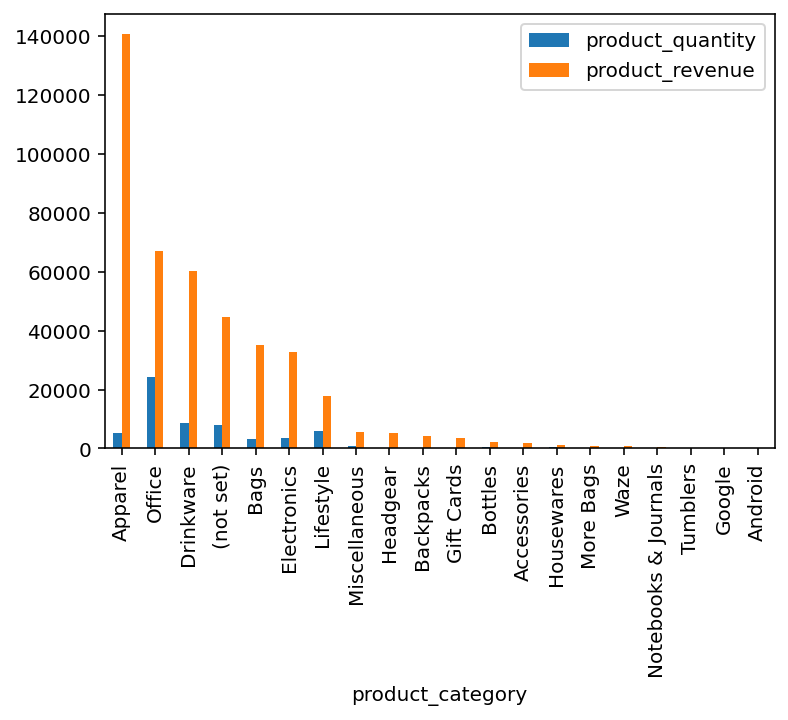

In [18]:
# create a pivot table that shows the Top 10 selling product categories
pivot = pd.pivot_table(df_6, index=['product_category'], values=['product_revenue', 'product_quantity'], aggfunc=np.sum).sort_values(by='product_revenue', ascending=False)
pivot.plot(kind='bar')

### What was the product price distribution and are there any outliers?
The average product price on the Google Merchandise store is around \\$18. We can see that based on the histogram that products on the online store ranged from \\$0.80 to \\$250, but products under \\$50 were sold the most frequently. As we start to explore the products by product category we can see that the median price varied across product categories with backpacks having the highest median average price. Bottles, Google, Headgear, among others have comparatively short box plots suggesting that overall products within each category are priced within similar ranges, while Electronics, Apparel, and Office have quite different selling prices with multiple outliers.

In [19]:
# describe product data frame
df_6.describe()

,product_price,product_quantity,product_revenue,total_revenue
count,9771.000000,9771.000000,9771.000000,9771.000000
mean,17.882065,6.294443,43.452829,258.212525
std,20.433374,21.266044,111.956400,443.151826
min,0.790000,1.000000,1.153636,3.200000
25%,3.500000,1.000000,12.790000,47.210000
50%,13.590000,1.000000,20.490000,97.210000
75%,19.990000,3.000000,45.390000,256.910000
max,250.000000,850.000000,7003.500000,7003.500000


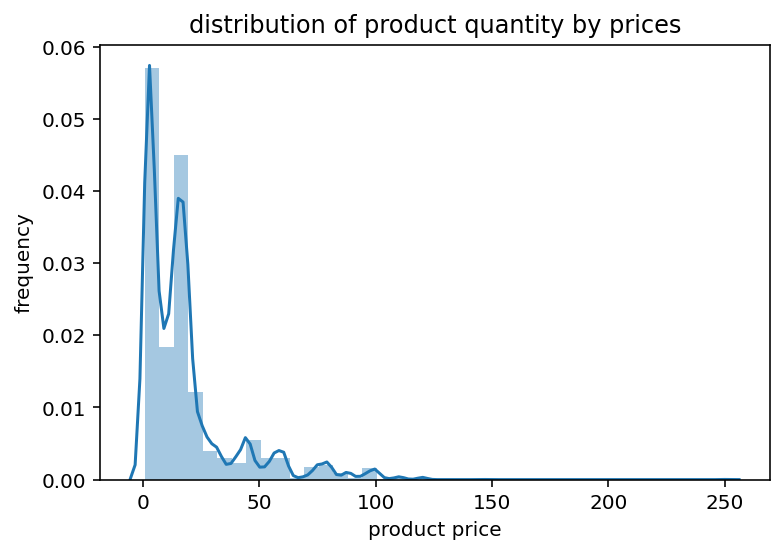

In [20]:
# histogram of product price
hist = sns.distplot(df_6['product_price'], bins=40)
hist.set_title('distribution of product quantity by prices');
hist.set_xlabel('product price');
hist.set_ylabel('frequency');

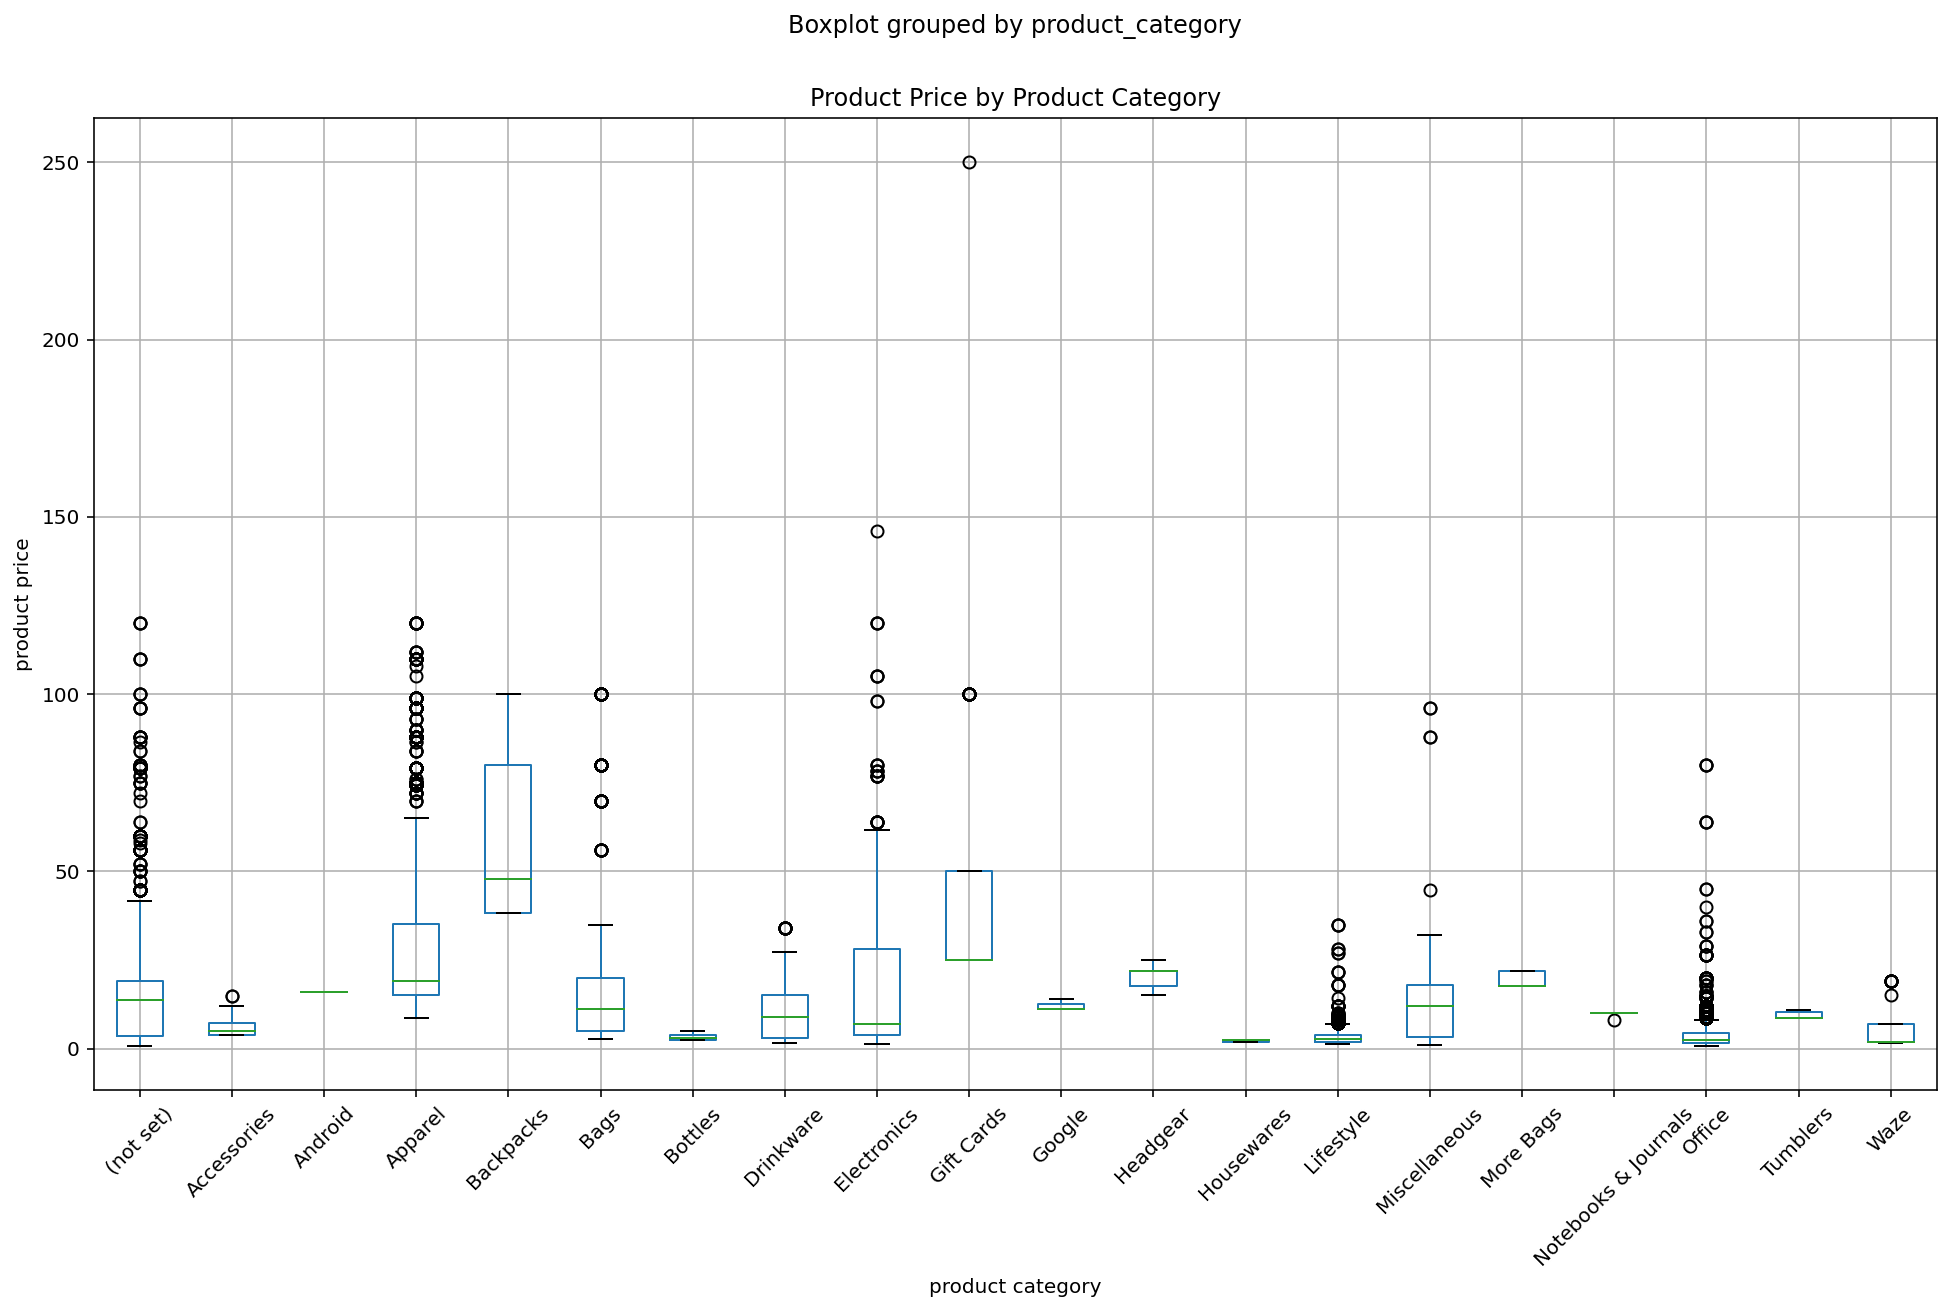

In [21]:
# distribution of selling price by product category
box_plot = df_6.boxplot(column='product_price', by='product_category', figsize=(16,9));
box_plot.set_title('Product Price by Product Category');
box_plot.set_xlabel('product category');
box_plot.set_ylabel('product price');
box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=45);

### Abandoned Cart visualization

In [22]:
# create a data frame calling action features
query = """
    SELECT
        hits.eCommerceAction.action_type AS actions,
        COUNT(fullVisitorId) AS total_hits
    FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
      UNNEST(hits) AS hits,
      UNNEST(hits.product) AS product
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
    AND
        (hits.ecommerceaction.action_type != '0' AND hits.ecommerceaction.action_type != '4' AND hits.ecommerceaction.action_type != '3')
    GROUP BY 
        1
    ORDER BY 1
"""
safe_query_job = client.query(query)
df_7 = safe_query_job.to_dataframe()
df_7.head()

,actions,total_hits
0,1,111457
1,2,92030
2,5,60395
3,6,19802


In [23]:
# define action types. Action types can be found in BigQuery Export schema: https://support.google.com/analytics/answer/3437719?hl=en
df_7['actions'] = df_7['actions'].astype(str) # convert action types to string

df_7['actions'] = df_7['actions'].replace(['0','1','2','3','4','5','6'],['Unknown', 
                                                                     'Click through of product lists', 
                                                                     'Product detail views', 
                                                                     'Add product(s) to cart',
                                                                     'Remove products from cart',
                                                                     'Check out',
                                                                     'Completed purchase'])
df_7


,actions,total_hits
0,Click through of product lists,111457
1,Product detail views,92030
2,Check out,60395
3,Completed purchase,19802


In [24]:
# create a funnel visualization
fig = go.Figure(go.Funnel(
    y = df_7['actions'],
    x = df_7['total_hits'],
    textposition = 'inside',
    textinfo = 'value+percent initial'))

fig.update_layout(title_text = 'Shopping Cart Abandonment')

fig.show()